# Process experimental data

Here we process experimental movies into a usable format

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Data processing

551 802 48


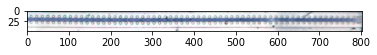

In [34]:
cap = cv2.VideoCapture('data/burgers1d.avi')
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(frameCount, frameWidth, frameHeight, flush=True)

frame_mean = None

fc = 0
ret = True

while (fc < frameCount  and ret):
    ret, a = cap.read()
    if frame_mean is None:
        frame_mean = a.astype(np.float32) / frameCount
    else:
        frame_mean += a.astype(np.float32) / frameCount
    fc += 1

frame_mean = frame_mean.astype(int)
plt.imshow(frame_mean)

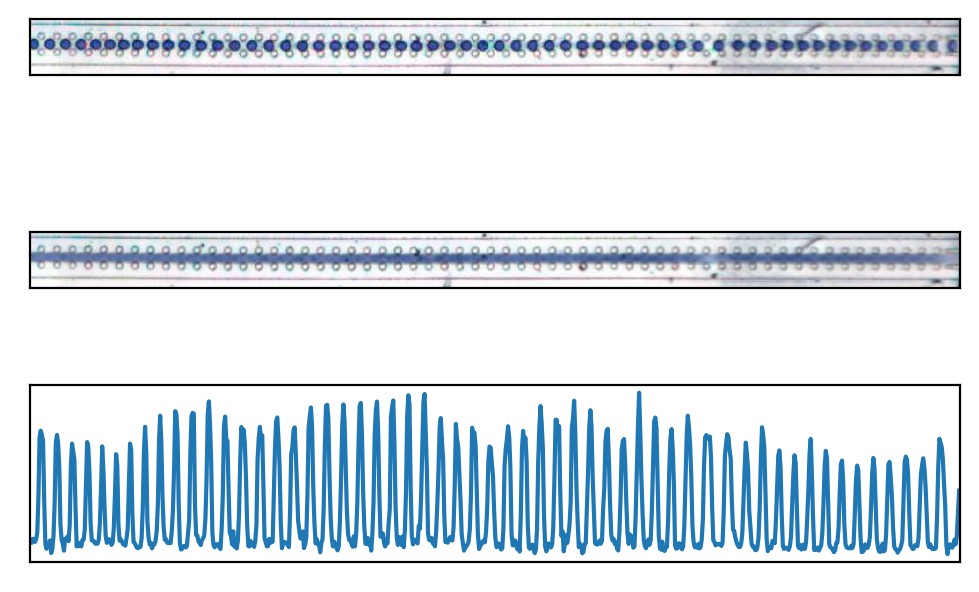

In [38]:
fig, ax = plt.subplots(3, 1, dpi=200, sharex=True)
ax[0].imshow(a, interpolation=None)
ax[1].imshow(frame_mean, interpolation=None)

sub = a - frame_mean
sub[sub < 0] = 0
sub = np.mean(sub, axis=(0, 2))
ax[2].plot(sub)

for axis in ax: 
    axis.set(yticks=[], xticks=[])

In [49]:
cap = cv2.VideoCapture('data/burgers1d.avi')
fc = 0
ret = True
data_1d = []
while (fc < frameCount  and ret):
    ret, a = cap.read()
    sub = a - frame_mean
    sub[sub < 0] = 0
    sub = np.mean(sub, axis=(0, 2))
    data_1d.append(sub)

    fc += 1
data_1d = np.stack(data_1d) #T, X
print(data_1d.shape)

(551, 802)


(551, 802) (112, 200)


Text(0.5, 0, 'Time')

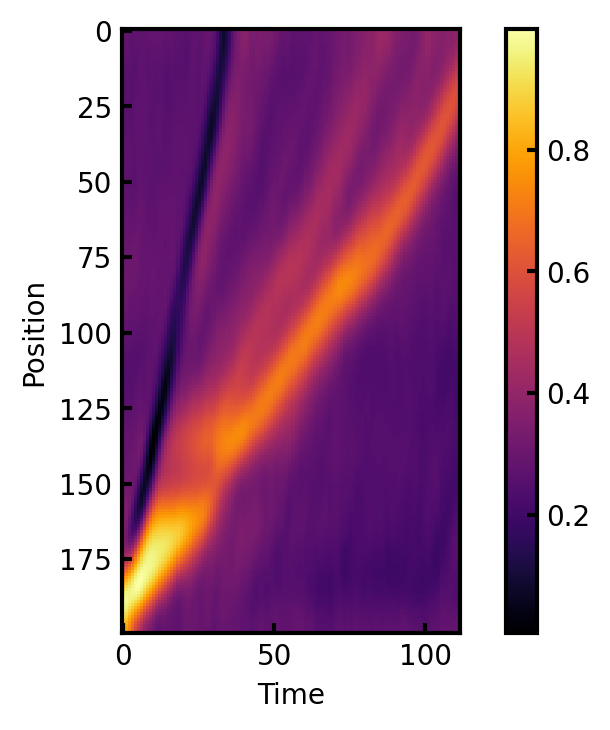

In [77]:
from scipy.ndimage import gaussian_filter1d, gaussian_filter, median_filter
from skimage.transform import downscale_local_mean

data_1d = np.load('data/data_1d.npy')

smoothed_1d = gaussian_filter(data_1d, sigma=(3, 25)) #Slight gaussian filter in time to remove microscopic artifiacts
smoothed_1d /= np.mean(smoothed_1d[:10, :],axis=0)
smoothed_1d = 1 - (smoothed_1d - np.min(smoothed_1d)) / np.ptp(smoothed_1d)

downsampled = downscale_local_mean(smoothed_1d, (4, 4))[:-1, :-1]

#Remove time before perturbation
downsampled = downsampled[25:]

print(smoothed_1d.shape, downsampled.shape)
plt.figure(dpi=200)
plt.imshow(downsampled.T, 
           origin='upper', cmap='inferno')
plt.colorbar()
plt.ylabel('Position')
plt.xlabel('Time')

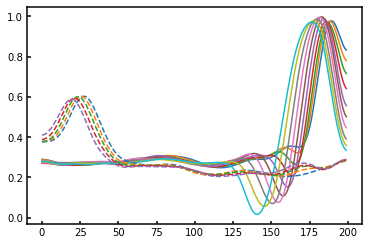

In [78]:
plt.plot((downsampled[:10, :]).T)
plt.plot((downsampled[-5:, :]).T, linestyle='--')

In [79]:
np.save('data/data_1d', data_1d)
np.save('data/smoothed_1d', smoothed_1d)
np.save('data/rescaled_1d', downsampled)

## Plots for Figure 1

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
linewidth = 1
fontsize = 6
plt.rcParams['axes.linewidth'] = linewidth
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.labelpad'] = 1.5
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = fontsize
plt.rcParams['image.origin'] = 'upper'

cap = cv2.VideoCapture('data/burgers1d.avi')
u = np.load('data/rescaled_1d.npy', mmap_mode='r')
tmin, xmin = 0, 0
frame_rate = 60 / 4
pixel_size = 18 / (u.shape[1]) #mm
tmax = u.shape[0] / frame_rate
xmax = u.shape[1] * pixel_size
times = [.5, 1.5, 2.5]

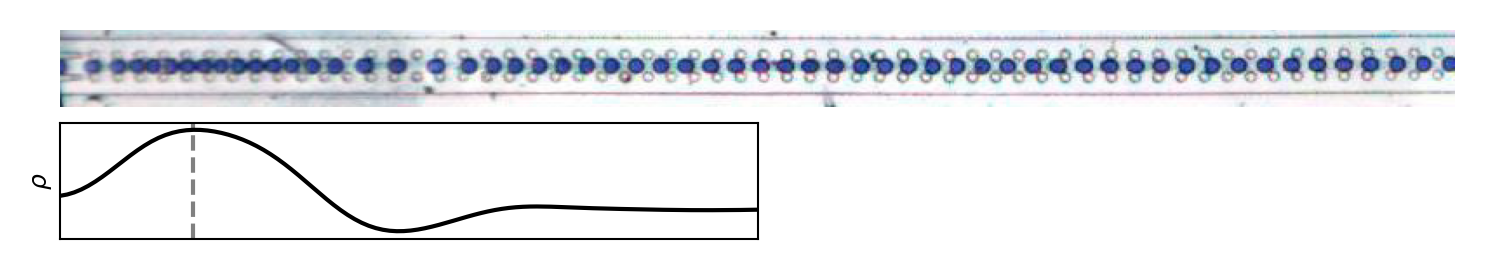

In [3]:
plt.rcParams['axes.linewidth'] = 0.5
xlim = [0, 9]
time = 0.5
frame = int(time * 60 + 25*4)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
ret, a = cap.read()

    
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=300)
ax.imshow(a[:, ::-1], extent=[xmin, xmax, 0, 1])
ax.set(xticks=[], yticks=[]);
ax.axis('off')

ax2 = ax.inset_axes([0, -1.7, .5, 1.5])

frame = int(time * 15)
x = np.linspace(xmin, xmax, u.shape[1])
ax2.plot(x, u[frame, ::-1], color='black', lw=1)
ax2.set(xticks=[], yticks=[], xlim=xlim, ylim=[0.0, 1.05], ylabel=r'$\rho$')
ax2.axvline(x[np.argmax(u[frame, ::-1])], color='grey', linestyle='--', lw=1, zorder=0)

#plt.savefig(f'/home/jcolen/OneDrive/MicrofluidicsGFNN/Panels/Experiment_figure.svg', bbox_inches='tight')

[ 0 22 45]
0 (200,) (112, 200) (0.8018915801614763, 0.8018915801614763, 0.8018915801614763, 1.0)
22 (200,) (112, 200) (0.4281430219146482, 0.4281430219146482, 0.4281430219146482, 1.0)
45 (200,) (112, 200) (0.0, 0.0, 0.0, 1.0)


[(0.0, 9.0),
 (0.0, 1.05),
 Text(0.5, 0, '$x$ (mm)'),
 Text(0, 0.5, '$\\rho$')]

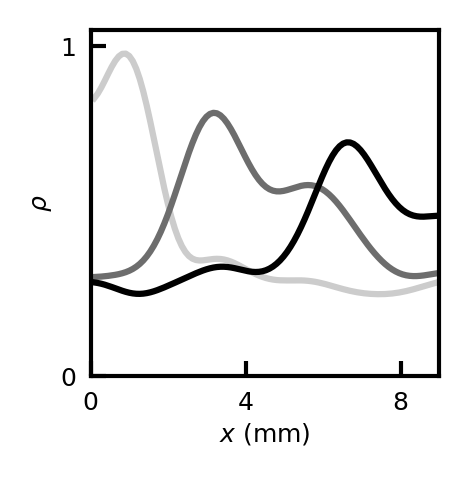

In [4]:
plt.rcParams['axes.linewidth'] = 1
times = [0, 1.5, 3]
times = np.array(times) * frame_rate
times = times.astype(int)
print(times)

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5), dpi=300)

offset = 20
colors = [plt.cm.Greys((j+offset) / (times[-1]+offset)) for j in times]
for (t, color) in zip(times, colors):
    print(t, x.shape, u.shape, color)
    ax.plot(x[1:-1], u[t, ::-1][1:-1], c=color)
    
ax.set(xlim=[0, 9], ylim=[0, 1.05], 
       xticks=[0, 4, 8], yticks=[0, 1],
       xlabel='$x$ (mm)', ylabel=r'$\rho$')

#plt.savefig('/home/jcolen/OneDrive/MicrofluidicsGFNN/Panels/DensityPlots_Experiment.svg', bbox_inches='tight')

0.006666666666666667 (0.8018915801614763, 0.8018915801614763, 0.8018915801614763, 1.0)
0.1 (0.4281430219146482, 0.4281430219146482, 0.4281430219146482, 1.0)
0.2 (0.0, 0.0, 0.0, 1.0)


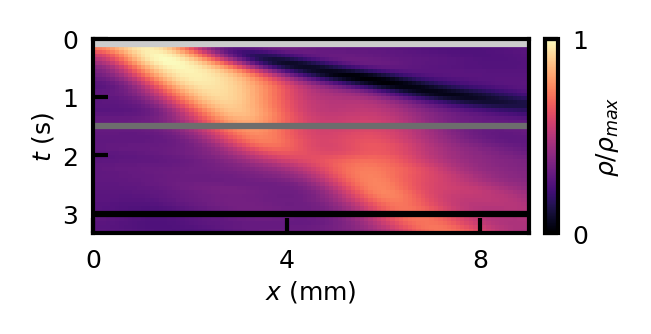

In [8]:
plt.rcParams['axes.linewidth'] = 1
kwargs = dict(cmap='magma', extent=[xmin, xmax, tmax, tmin], vmin=0, vmax=1)
        
fig, ax = plt.subplots(1, 1, figsize=(3, 1), dpi=300, constrained_layout=True)

#Note - video flows right to left, but we present things left to right
im = ax.imshow(u[:, ::-1], **kwargs)

ax.set_aspect(xmax / tmax / 2.)
ax.set(xlabel='$x$ (mm)', xticks=[0, 4, 8], xlim=[0, 9],
       ylabel='$t$ (s)', yticks=[0, 1, 2, 3], ylim=[3.3333, 0]);

times = [0.1, 1.5, 3]
for t, color in zip(times, colors):
    print(t / frame_rate, color)
    ax.axhline(t, color=color, linestyle='-')

c = fig.colorbar(im, pad=0.02, aspect=15)
c.ax.set(yticks=[0, 1], ylabel=r'$\rho / \rho_{max}$')
    
plt.savefig('Figures/DensityField_Experiment.svg', bbox_inches='tight')

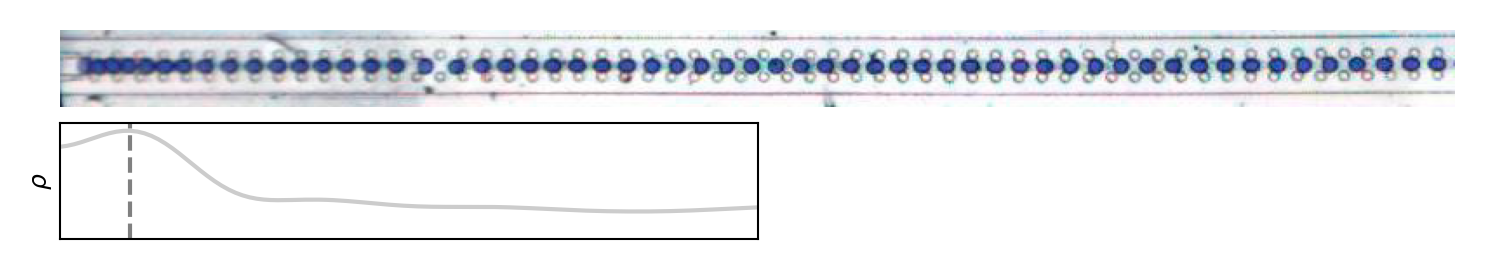

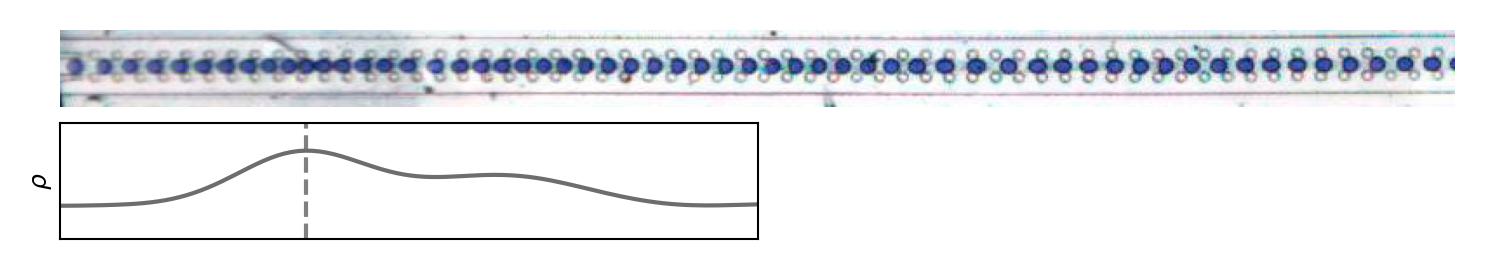

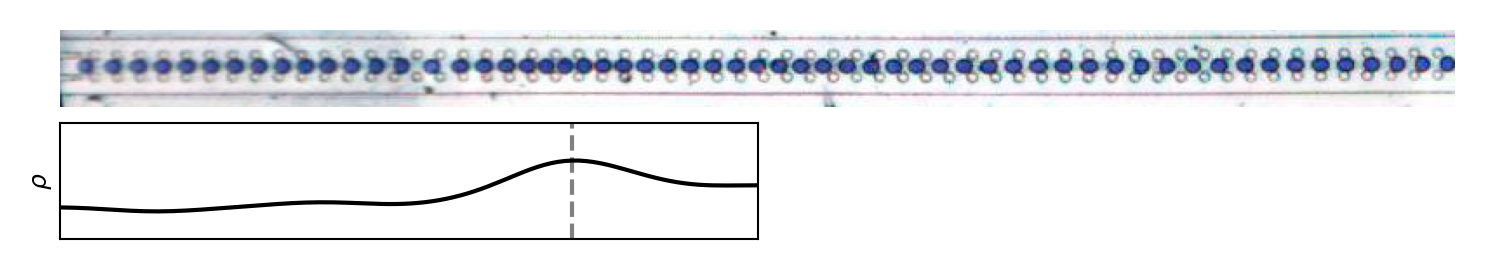

In [9]:
plt.rcParams['axes.linewidth'] = 0.5
xlim = [0, 9]
times = [0, 1.5, 3]

for time, color in zip(times, colors):
    frame = int(time * 60 + 25*4)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    ret, a = cap.read()
    fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=300)
    ax.imshow(a[:, ::-1], extent=[xmin, xmax, 0, 1])
    ax.set(xticks=[], yticks=[]);
    ax.axis('off')
    
    ax2 = ax.inset_axes([0, -1.7, .5, 1.5])
    
    frame = int(time * 15)
    x = np.linspace(xmin, xmax, u.shape[1])
    ax2.plot(x, u[frame, ::-1], color=color, lw=1)
    ax2.set(xticks=[], yticks=[], xlim=xlim, ylim=[0.0, 1.05], ylabel=r'$\rho$')
    ax2.axvline(x[np.argmax(u[frame, ::-1])], color='grey', linestyle='--', lw=1, zorder=0)
    
    #plt.savefig(f'/home/jcolen/OneDrive/MicrofluidicsGFNN/Panels/Experiment_t={time}.svg', bbox_inches='tight')

0 18.0


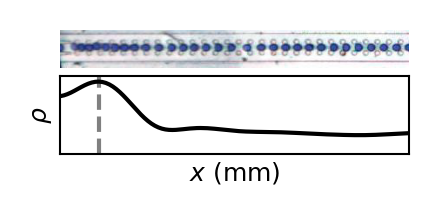

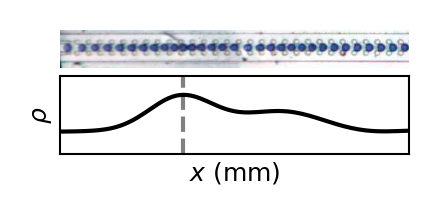

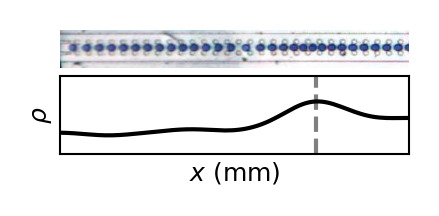

In [10]:
plt.rcParams['axes.linewidth'] = 0.5
xlim = [0, 9]

print(xmin, xmax)

for time in times:
    frame = int(time * 60 + 25*4)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    ret, a = cap.read()

        
    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1), dpi=300)
    ax.imshow(a[:, ::-1], extent=[xmin, xmax, 0, 1])
    ax.set(xticks=[], yticks=[], xlim=xlim);
    ax.axis('off')
    
    ax2 = ax.inset_axes([0, -2.2, 1, 2])
    
    frame = int(time * 15)
    x = np.linspace(xmin, xmax, u.shape[1])
    ax2.plot(x, u[frame, ::-1], color='black', lw=1)
    ax2.set(xticks=[], yticks=[], xlim=xlim, ylim=[0.0, 1.05], ylabel=r'$\rho$', xlabel='$x$ (mm)')
    ax2.axvline(x[np.argmax(u[frame, ::-1])], color='grey', linestyle='--', lw=1, zorder=0)

    #plt.savefig(f'/home/jcolen/OneDrive/MicrofluidicsGFNN/Panels/Experiment_t={time}.svg', bbox_inches='tight')

0 18.0


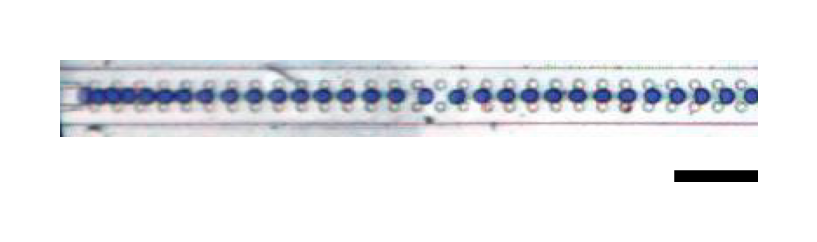

In [17]:
plt.rcParams['axes.linewidth'] = 0.5
xlim = [0, 9]
time = 0


print(xmin, xmax)

frame = int(time * 60 + 25*4)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
ret, a = cap.read()

    
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1), dpi=600)
ax.imshow(a[:, ::-1], extent=[xmin, xmax, 0, 1])

# 1 mm scale bar
ax.plot([8, 9], [-0.5, -0.5], color='black')

ax.set(xticks=[], yticks=[], xlim=xlim);
ax.axis('off')

plt.savefig('Figures/ExperimentalPicture.svg', bbox_inches='tight')